<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Korg" data-toc-modified-id="Import-Korg-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Korg</a></span></li><li><span><a href="#Wavelength-Array-and-linelist" data-toc-modified-id="Wavelength-Array-and-linelist-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Wavelength Array and linelist</a></span></li><li><span><a href="#Resolution-and-Line-Spread-Function" data-toc-modified-id="Resolution-and-Line-Spread-Function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Resolution and Line-Spread-Function</a></span></li><li><span><a href="#Calculate-the-4-example-Gaia-FGK-benchmark-stars-from-Jofre-et-al.-(2017)" data-toc-modified-id="Calculate-the-4-example-Gaia-FGK-benchmark-stars-from-Jofre-et-al.-(2017)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate the 4 example Gaia FGK benchmark stars from Jofre et al. (2017)</a></span></li></ul></div>

# Korg Flux for Veloce

This notebook contains the code necessary to calculate 
./VeloceReduction/VeloceReduction/korg_flux/korg_flux_sun_arcturus_61cyga_hd22879_R80000_3590_0.01_9510AA.fits

If you do want to recreate this computation (rather than just use it), you need both the language Julia and the Julia package Korg.  
Visit https://ajwheeler.github.io/Korg.jl/stable/ for installation instructions of both.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

## Import Korg

In [2]:
# Julia part: Korg for spectrum synthesis
try:
    from juliacall import Main as jl
    jl.seval("using Korg")
    Korg = jl.Korg
except ImportError as e:
    error_message = (
        f"Failed to import 'juliacall' in python and/or 'Korg' in julia. Please make sure it is installed. "
        f"Visit https://ajwheeler.github.io/Korg.jl/stable/ for installation instructions."
    )
    raise ImportError(error_message) from e

In [3]:
# Julia part: JLD, FileIO for LSF matrix
try:
    jl.seval("using JLD2, FileIO, Serialization")
except ImportError as e:
    try:
        jl.seval("using Pkg")
        jl.Pkg.add("JLD2")
        jl.Pkg.add("FileIO")
    except ImportError as e:
        error_message = (
            f"Failed to install 'JLD2' and 'File'."
        )
        raise ImportError(error_message) from e
    error_message = (
        f"Failed to import 'JLD2' and 'File' for julia."
    )
    raise ImportError(error_message) from e

## Wavelength Array and linelist

In [4]:
# Create julia-array of Korg wavelengths (note: vacuum!)
korg_wavelength_vacuum_start = 3500
korg_wavelength_vacuum_step = 0.01
korg_wavelength_vacuum_end = 9600
korg_wavelength_vacuum = jl.seval('['+str(korg_wavelength_vacuum_start)+':'+str(korg_wavelength_vacuum_step)+':'+str(korg_wavelength_vacuum_end)+']')
korg_wavelength_air = np.array([Korg.vacuum_to_air(pixel) for pixel in np.arange(korg_wavelength_vacuum_start, korg_wavelength_vacuum_end+korg_wavelength_vacuum_step, korg_wavelength_vacuum_step)])
korg_wavelength_vac = np.array([pixel for pixel in np.arange(korg_wavelength_vacuum_start, korg_wavelength_vacuum_end+korg_wavelength_vacuum_step, korg_wavelength_vacuum_step)])

In [5]:
# Actually this has to be recomputed with a much larger linelist!
# This one stops at 9000Å and is only including lines visible in the Sun.
korg_lines_default = Korg.get_VALD_solar_linelist()
korg_lines_sun_0p01 = Korg.read_linelist('vald_linelist_sun_3500_9600_0.01_1.06_5771_4.44_0.03.vald')
korg_lines_sun_0p001 = Korg.read_linelist('vald_linelist_sun_3500_9600_0.001_1.06_5771_4.44_0.03.vald')
korg_lines_arcturus_0p01 = Korg.read_linelist('vald_linelist_arcturus_3500_9600_0.01_1.58_4286_1.64_-0.52.vald')
korg_lines_arcturus_0p001 = Korg.read_linelist('vald_linelist_arcturus_3500_9600_0.001_1.58_4286_1.64_-0.52.vald')
korg_lines_hd22879_0p01 = Korg.read_linelist('vald_linelist_hd22879_3500_9600_0.01_1.05_5868_4.27_-0.86.vald')
korg_lines_hd22879_0p001 = Korg.read_linelist('vald_linelist_hd22879_3500_9600_0.001_1.05_5868_4.27_-0.86.vald')
korg_lines_61cyga_0p01 = Korg.read_linelist('vald_linelist_61cyga_3500_9600_0.01_1.07_4373_4.63_-0.33.vald')
korg_lines_61cyga_0p001 = Korg.read_linelist('vald_linelist_61cyga_3500_9600_0.001_1.07_4373_4.63_-0.33.vald')
korg_lines_hip28011_0p01 = Korg.read_linelist('vald_linelist_hip28011_3500_9600_0.01_1.0_4565_2.50_0.26.vald')
korg_lines_hip28011_0p001 = Korg.read_linelist('vald_linelist_hip28011_3500_9600_0.001_1.0_4565_2.50_0.26.vald')

## Resolution and Line-Spread-Function

In [6]:
# Try to read in the LSF file as sparse matrix:
try:
    jl.seval("""
    function load_jld2_matrix(filepath)
        return load(filepath)["korg_lsf"]
    end
    """)
    korg_lsf = jl.load_jld2_matrix("lsf_matrix_lsf_korg_3500_0p01_9600.jld2")
    print(f"LSF Matrix File read in successfully.")
except:
    try:
        jl.seval("""
        begin
        using Korg
        using JLD2, FileIO
        korg_wavelength_vacuum = 3500:0.01:9600
        korg_lsf = Korg.compute_LSF_matrix(
            korg_wavelength_vacuum,
            korg_wavelength_vacuum,
            80_000)
        @save "lsf_matrix_lsf_korg_3500_0p01_9600.jld2" korg_lsf
        end
        """)
    except:
        raise FileNotFoundError("Could neither read in LSF nor compute it. You have to either find a computer that can compute this or contact the authors.")

LSF Matrix File read in successfully.


## Calculate the 4 example Gaia FGK benchmark stars from Jofre et al. (2017)

In [7]:
def calculate_korg_spectrum(teff, logg, fe_h, vmic = 1.0, vsini=5.0, epsilon=0.6, korg_lines = None, atmosphere = 'marcs', normalise_flux=False, debug=False):
    """
    Calculate a synthetic stellar spectrum using the Korg library based on input stellar parameters.

    This function generates a spectrum by interpolating within a grid of pre-computed models
    according to the given stellar parameters. It can also apply rotational broadening and
    optionally normalise the resulting flux.

    Parameters:
    - teff (float): Effective temperature of the star in Kelvin.
    - logg (float): Logarithm (base 10) of the surface gravity in cm/s^2.
    - fe_h (float): Metallicity [Fe/H], representing the logarithmic iron abundance relative to hydrogen,
      compared to the Sun.
    - vmic (float, optional): Microturbulence velocity in km/s. Default is 1.0 km/s.
    - vsini (float, optional): Projected rotational velocity of the star in km/s. Default is 5.0 km/s.
    - epsilon (float, optional): Limb darkening coefficient, used in the rotational broadening. 
      It ranges from 0 to 1, where 0 means no limb darkening and 1 represents full limb darkening. 
      Default is 0.6.
    - korg_lines: korg linelist to be used for synthesis. if None, the default linelist (3000-9000Å) for the Sun will be used.
    - atmosphere = 'marces' or 'atlas'
    - normalise_flux (bool, optional): If True, the output flux will be normalised to 1. Default is False.
    - debug (bool, optional): If True, additional debug information will be printed during the computation. 
      Default is False.

    Returns:
    - spectrum (array-like): The calculated synthetic spectrum, which includes wavelengths and corresponding fluxes.
      The specific format of the output depends on the Korg library's conventions.

    Raises:
    - ValueError: If any of the input parameters are out of the acceptable range for the Korg library.

    Examples:
    - Calculate a simple spectrum:
        >>> calculate_korg_spectrum(5700, 4.5, -0.2)
    - Calculate a spectrum with rotational broadening and normalisation:
        >>> calculate_korg_spectrum(5700, 4.5, -0.2, vsini=10.0, normalise_flux=True)

    Note:
    This function assumes that the Korg library and necessary data files are correctly installed and configured.
    
    Korg computes stellar spectra from 1D model atmospheres and linelists assuming local thermodynamic equilibrium.
    If you make use of Korg, please cite [Wheeler et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023AJ....165...68W/abstract) as well as [Wheeler et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...83W/abstract). For more information, take a look at Korg's [documentation](https://ajwheeler.github.io/Korg.jl/stable/).

    This interface is meant to compute synthetic Korg spectra for Fornax at MAVIS (3700-9400Å) wavelength and resolution (R=20,000).
    """

    # Create parameter dictionary
    fixed_parameters = {'teff':teff, 'logg':logg, 'fe_h':fe_h, 'vmic':vmic, 'vsini':vsini, 'epsilon':epsilon}
    
    if debug:
        start_time = time.time()
        print('Calculating Korg spectrum with fixed parameters: ',fixed_parameters)
    
    # Create the A(X) dictionary for synthesising lines with Korg
    # Korg can use fe_h and alpha_h, or even individual abundances as input.
    # For this computation, we assume the standard alpha-enhancement, i.e.
    # [alpha/Fe] = 0.4 for [Fe/H] < -1.0
    # [alpha/Fe] = 0.0 for [Fe/H] > 0.0
    # [alpha/Fe] = -0.4 * fe_h below
    alpha_fe = -0.4 * fe_h
    if alpha_fe > 0.4: alpha_fe = 0.4
    if alpha_fe < 0.0: alpha_fe = 0.0
    # transform alpha_fe into alpha_h
    alpha_h = alpha_fe + fe_h
    # finally create Korg's abundance dictionary
    a_x_dictionary = Korg.format_A_X(fe_h, alpha_h)
    if debug:
        print('   --> A(X) scale assumes Asplund et al. (2021), and [alpha/Fe]='+str(alpha_fe)+' (i.e. [alpha/H]='+str(alpha_h)+')')
        a_x_time = time.time()

        print('   --> Interpolating extended model atmosphere')
    # Interpolate the model atmosphere
    if atmosphere == 'marcs':
        atmosphere = Korg.interpolate_marcs(teff, logg, a_x_dictionary)
    elif atmosphere == 'atlas':
        atmosphere = Korg.interpolate_(teff, logg, a_x_dictionary)
    
    if debug:
        interpolation_time = time.time()
        print('   --> Synthesising Korg spectrum')
    # Synthesise the Korg spectrum
    
    if korg_lines is not None:
        synthesis = Korg.synthesize(atmosphere, korg_lines, a_x_dictionary, korg_wavelength_vacuum, vmic=vmic)
    else:
        synthesis = Korg.synthesize(atmosphere, korg_lines_default, a_x_dictionary, korg_wavelength_vacuum, vmic=vmic)
    
    if debug:
        synthesis_time = time.time()
        print('   --> Normalising spectrum? ',normalise_flux)
    if normalise_flux:
        # simply divide absolute flux by continuum flux
        korg_flux = np.array(synthesis.flux)/np.array(synthesis.cntm)
    else:
        korg_flux = np.array(synthesis.flux)    
    
    if debug:
        normalisation_time = time.time()
        print('   --> Applying rotation')
    # Broaden spectrum, first with rotation, then for instrumental profile via line-spread-function
    korg_flux = Korg.apply_rotation(korg_flux, korg_wavelength_vacuum, fixed_parameters["vsini"], fixed_parameters["epsilon"])
    
    if debug:
        broadening_time = time.time()

    if korg_lsf is not None:
        if debug:
            print('   --> Applying LSF')
        korg_flux = korg_lsf * korg_flux
        if debug:
            lsf_time = time.time()

    if debug:
        print('\nComputing time:')
        print('Computing A(X):          ',"{:.1f}".format(a_x_time - start_time)+'s')
        print('Computing Interpolation: ',"{:.1f}".format(interpolation_time - a_x_time)+'s')
        print('Computing Synthesis:     ',"{:.1f}".format(synthesis_time - interpolation_time)+'s')
        print('Computing Normalisation: ',"{:.1f}".format(normalisation_time - synthesis_time)+'s')
        print('Computing Broadening:    ',"{:.1f}".format(broadening_time - normalisation_time)+'s')
        print('Computing LSF:           ',"{:.1f}".format(lsf_time - broadening_time)+'s')

    return(korg_flux)

In [8]:
# Let's calculate 4 example spectra, with parameters from Jofre et al. (2017):
# http://adsabs.harvard.edu/abs/2017A%26A...601A..38J)

korg_sun_0p01 = calculate_korg_spectrum(
    teff = 5771.,
    logg = 4.44,
    fe_h = 0.03,
    vmic = 1.06,
    vsini = np.sqrt(1.6**2+4.2**2),
    epsilon=0.6,
    korg_lines=korg_lines_sun_0p01,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for Sun with 0p01')

korg_sun_0p001 = calculate_korg_spectrum(
    teff = 5771.,
    logg = 4.44,
    fe_h = 0.03,
    vmic = 1.06,
    vsini = np.sqrt(1.6**2+4.2**2),
    epsilon=0.6,
    korg_lines=korg_lines_sun_0p001,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for Sun with 0p001')

korg_arcturus_0p01 = calculate_korg_spectrum(
    teff = 4286.,
    logg = 1.64,
    fe_h = -0.52,
    vmic = 1.58,
    vsini = np.sqrt(3.8**2+5.0**2),
    epsilon=0.6,
    korg_lines=korg_lines_arcturus_0p01,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for Arcturus with 0p01')

korg_arcturus_0p001 = calculate_korg_spectrum(
    teff = 4286.,
    logg = 1.64,
    fe_h = -0.52,
    vmic = 1.58,
    vsini = np.sqrt(3.8**2+5.0**2),
    epsilon=0.6,
    korg_lines=korg_lines_arcturus_0p001,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for Arcturus with 0p001')

korg_61cyga_0p01 = calculate_korg_spectrum(
    teff = 4373,
    logg = 4.63,
    fe_h = -0.33,
    vmic = 1.07,
    vsini = np.sqrt(0.0**2+4.2**2),
    epsilon=0.6,
    korg_lines=korg_lines_61cyga_0p01,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for 61 Cyg A with 0p01')


korg_61cyga_0p001 = calculate_korg_spectrum(
    teff = 4373,
    logg = 4.63,
    fe_h = -0.33,
    vmic = 1.07,
    vsini = np.sqrt(0.0**2+4.2**2),
    epsilon=0.6,
    korg_lines=korg_lines_61cyga_0p001,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for 61 Cyg A with 0p001')

korg_hd22879_0p01 = calculate_korg_spectrum(
    teff = 5868,
    logg = 4.27,
    fe_h = -0.86,
    vmic = 1.05,
    vsini = np.sqrt(4.4**2+5.4**2),
    epsilon=0.6,
    korg_lines=korg_lines_hd22879_0p01,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for HD 22879 0p001')

korg_hd22879_0p001 = calculate_korg_spectrum(
    teff = 5868,
    logg = 4.27,
    fe_h = -0.86,
    vmic = 1.05,
    vsini = np.sqrt(4.4**2+5.4**2),
    epsilon=0.6,
    korg_lines=korg_lines_hd22879_0p001,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for HD 22879 0p001')

korg_18sco_0p01 = calculate_korg_spectrum(
    teff = 5824,
    logg = 4.42,
    fe_h = 0.03,
    vmic = 1.0,
    vsini = np.sqrt(2.03**2 + 3.7**2),
    # Using vsini of 2.03 ± 0.05 from Melendez et al. (2014, https://ui.adsabs.harvard.edu/abs/2014ApJ...791...14M)
    # and vmac = 3.7 from Tucci Maia et al. (2015, https://ui.adsabs.harvard.edu/abs/2015A%26A...576L..10T/abstract)
    epsilon=0.6,
    korg_lines=korg_lines_sun_0p01,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for 18 Sco 0p01')

korg_18sco_0p001 = calculate_korg_spectrum(
    teff = 5824,
    logg = 4.42,
    fe_h = 0.03,
    vmic = 1.0,
    vsini = np.sqrt(2.03**2 + 3.7**2),
    # Using vsini of 2.03 ± 0.05 from Melendez et al. (2014, https://ui.adsabs.harvard.edu/abs/2014ApJ...791...14M)
    # and vmac = 3.7 from Tucci Maia et al. (2015, https://ui.adsabs.harvard.edu/abs/2015A%26A...576L..10T/abstract)
    epsilon=0.6,
    korg_lines=korg_lines_sun_0p001,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for 18 Sco 0p001')

korg_hip28011_0p01 = calculate_korg_spectrum(
    teff = 4565,
    logg = 2.50,
    fe_h = 0.26,
    vmic = 1.0,
    vsini = 4.0,
    epsilon=0.6,
    korg_lines=korg_lines_arcturus_0p01,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for HIP 28011 0p01')

korg_hip28011_0p001 = calculate_korg_spectrum(
    teff = 4565,
    logg = 2.50,
    fe_h = 0.26,
    vmic = 1.0,
    vsini = 4.0,
    epsilon=0.6,
    korg_lines=korg_lines_arcturus_0p001,
    normalise_flux=True,
    debug=False
)
print('Done computing Korg spectrum for HIP 28011 0p001')




korg_fluxes = Table()
korg_fluxes['wavelength_air'] = np.array(korg_wavelength_air, dtype=np.float32)
korg_fluxes['wavelength_vac'] = np.array(korg_wavelength_vac, dtype=np.float32)
korg_fluxes['flux_sun_0p01'] = np.array(korg_sun_0p01, dtype=np.float32)
korg_fluxes['flux_sun'] = np.array(korg_sun_0p001, dtype=np.float32)
korg_fluxes['flux_arcturus_0p01'] = np.array(korg_arcturus_0p01, dtype=np.float32)
korg_fluxes['flux_arcturus'] = np.array(korg_arcturus_0p001, dtype=np.float32)
korg_fluxes['flux_61cyga_0p01'] = np.array(korg_61cyga_0p01, dtype=np.float32)
korg_fluxes['flux_61cyga'] = np.array(korg_61cyga_0p001, dtype=np.float32)
korg_fluxes['flux_hd22879_0p01'] = np.array(korg_hd22879_0p01, dtype=np.float32)
korg_fluxes['flux_hd22879'] = np.array(korg_hd22879_0p001, dtype=np.float32)
korg_fluxes['flux_18sco_0p01'] = np.array(korg_18sco_0p01, dtype=np.float32)
korg_fluxes['flux_18sco'] = np.array(korg_18sco_0p001, dtype=np.float32)
korg_fluxes['flux_hip28011_0p01'] = np.array(korg_hip28011_0p01, dtype=np.float32)
korg_fluxes['flux_hip28011'] = np.array(korg_hip28011_0p001, dtype=np.float32)

korg_fluxes_best = korg_fluxes[['wavelength_air','wavelength_vac','flux_sun','flux_arcturus','flux_61cyga','flux_hd22879','flux_18sco','flux_hip28011']]
korg_fluxes_best.write('korg_flux_sun_arcturus_61cyga_hd22879_18sco_hip28011_R80000_3500_0.01_9600AA.fits', overwrite=True)
print('Done saving wavelength arrays and fluxes')

Done computing Korg spectrum for Sun with 0p01
Done computing Korg spectrum for Sun with 0p001
Done computing Korg spectrum for Arcturus with 0p01
Done computing Korg spectrum for Arcturus with 0p001
Done computing Korg spectrum for 61 Cyg A with 0p01
Done computing Korg spectrum for 61 Cyg A with 0p001
Done computing Korg spectrum for HD 22879 0p001
Done computing Korg spectrum for HD 22879 0p001
Done computing Korg spectrum for 18 Sco 0p01
Done computing Korg spectrum for 18 Sco 0p001
Done computing Korg spectrum for HIP 28011 0p01
Done computing Korg spectrum for HIP 28011 0p001
Done saving wavelength arrays and fluxes


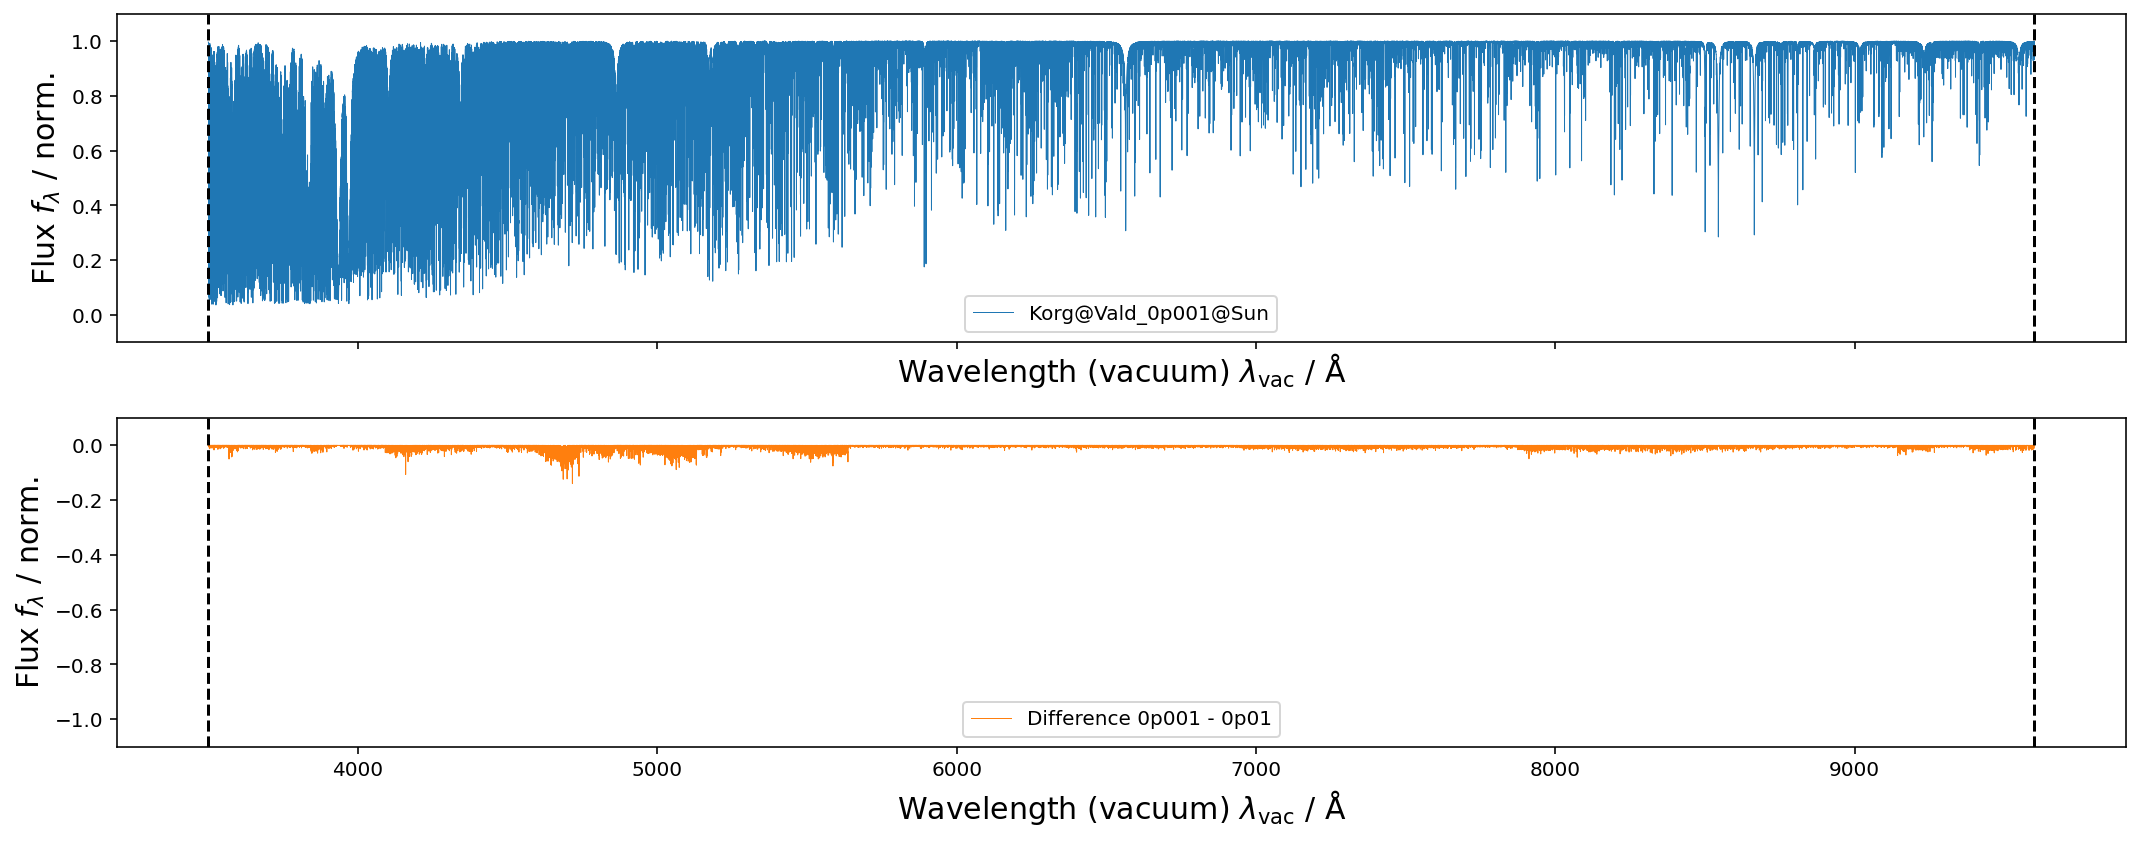

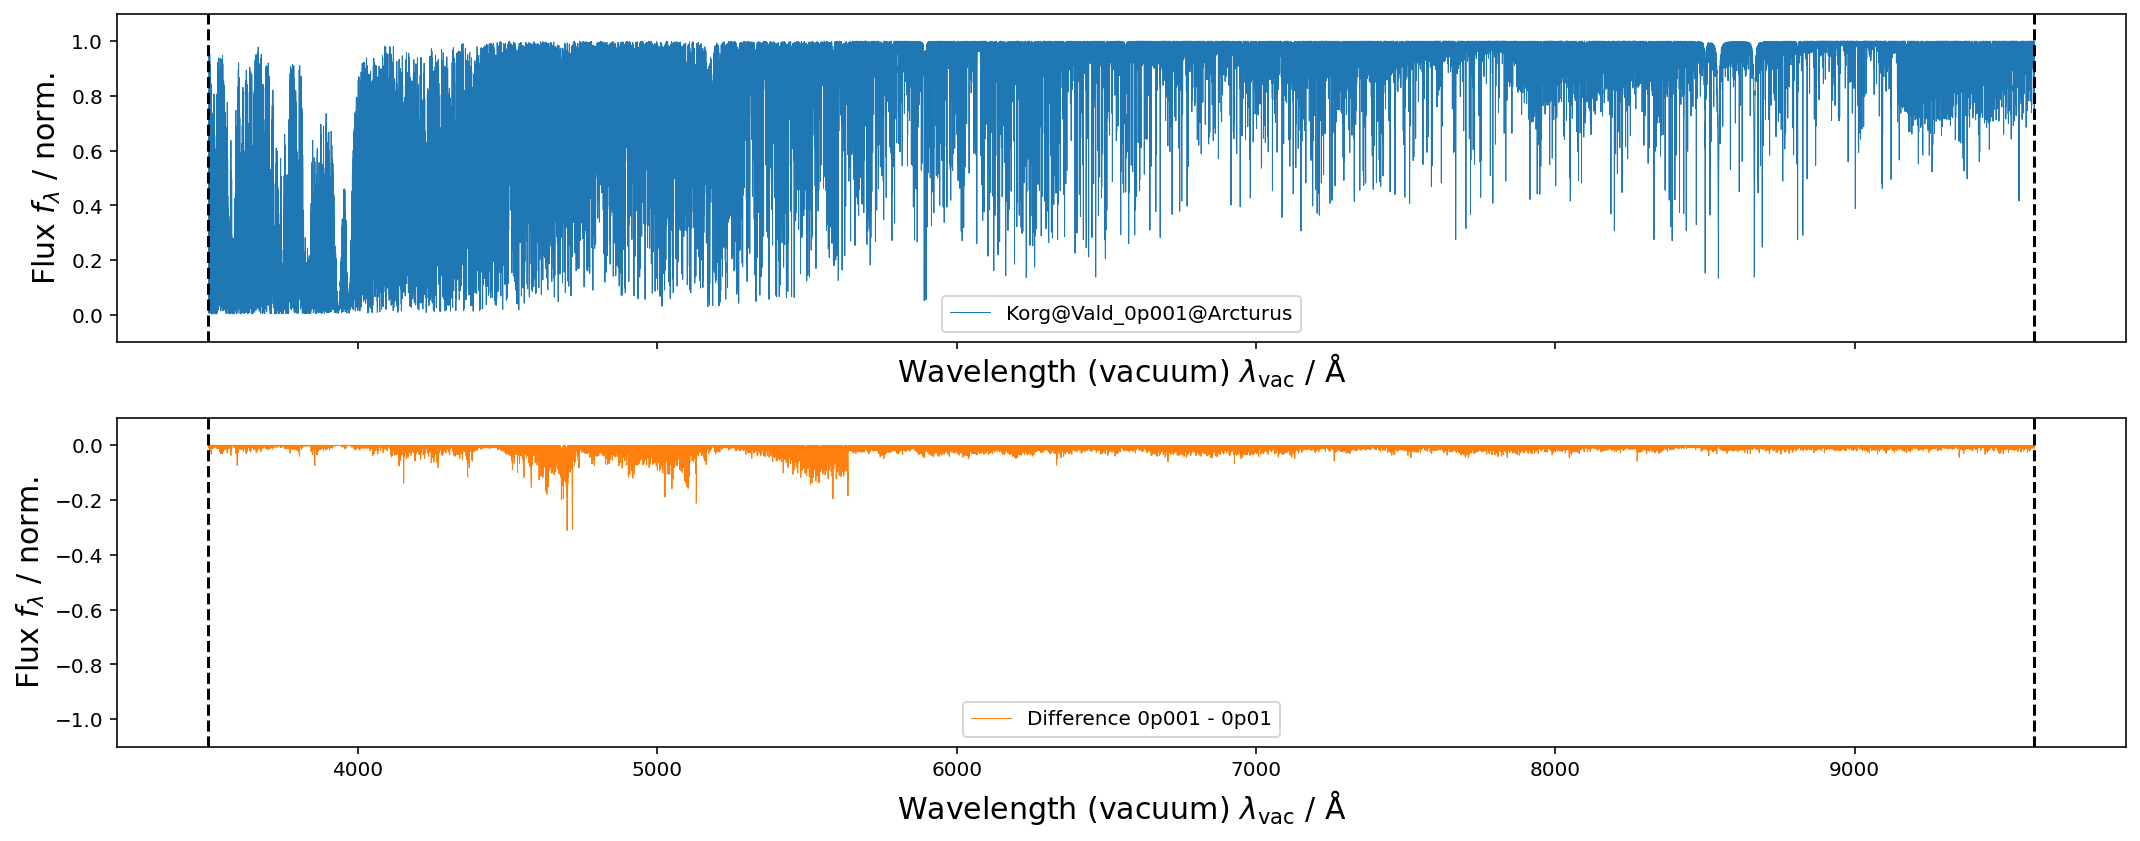

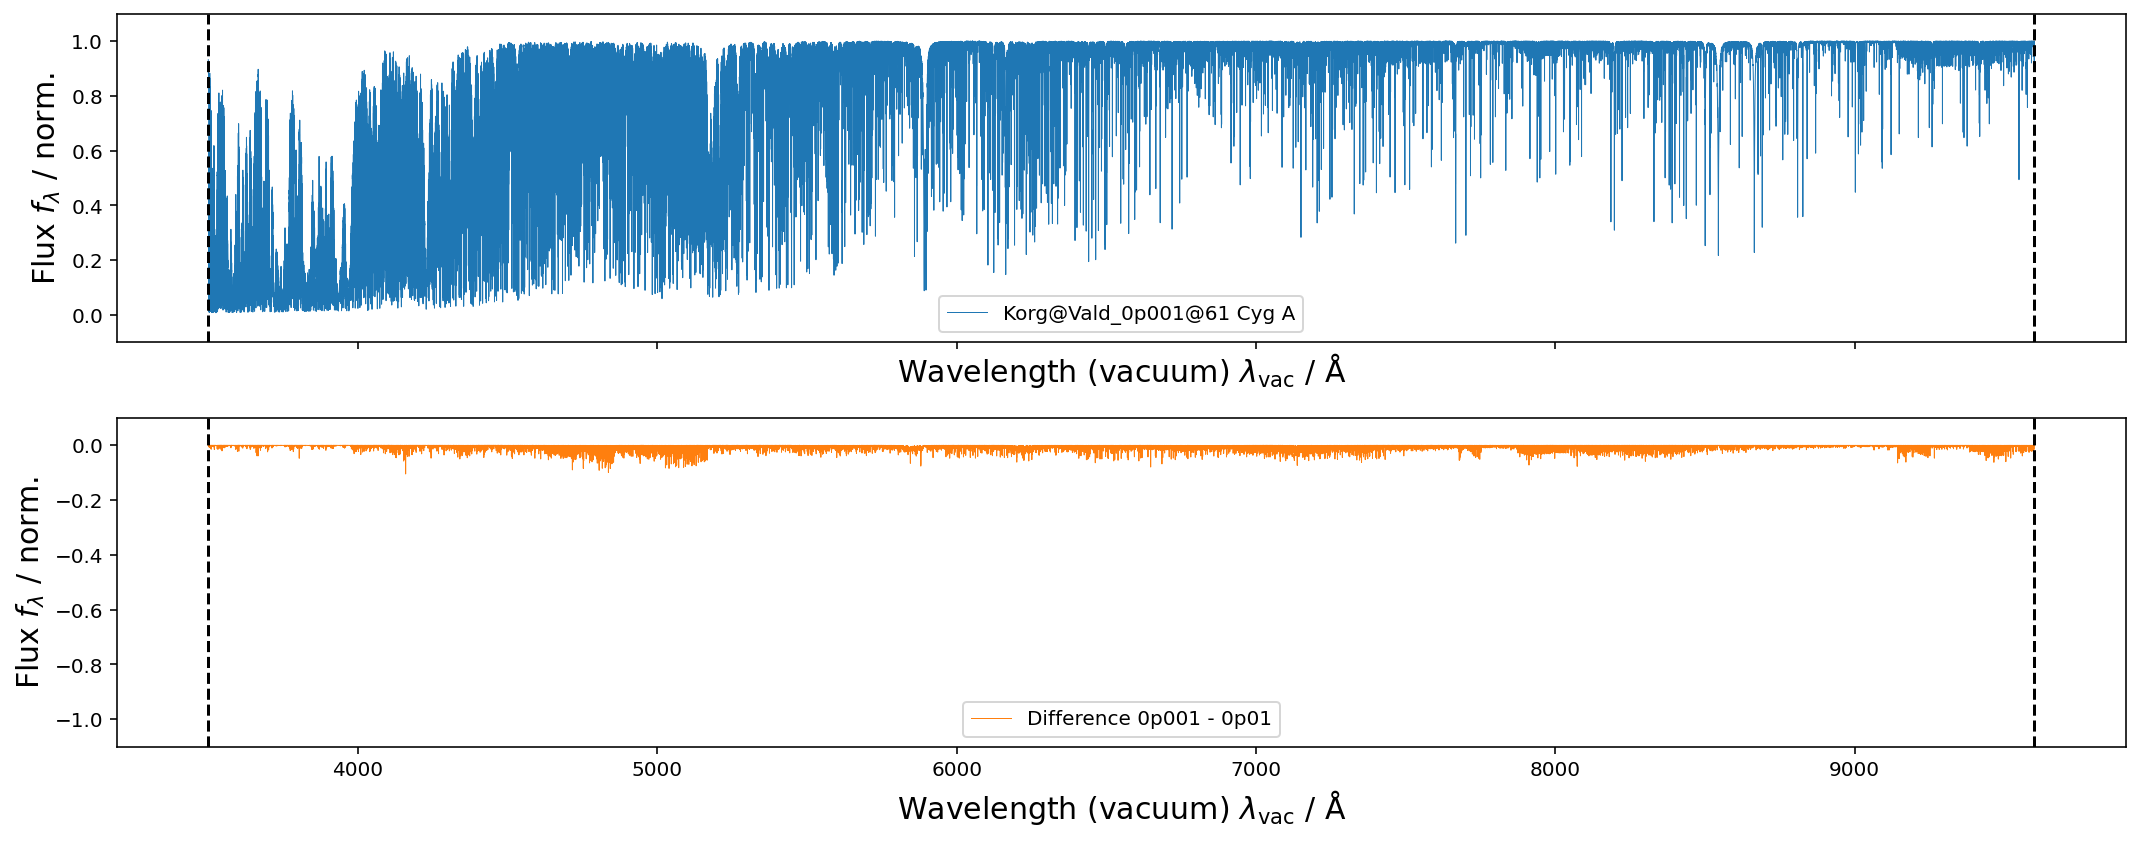

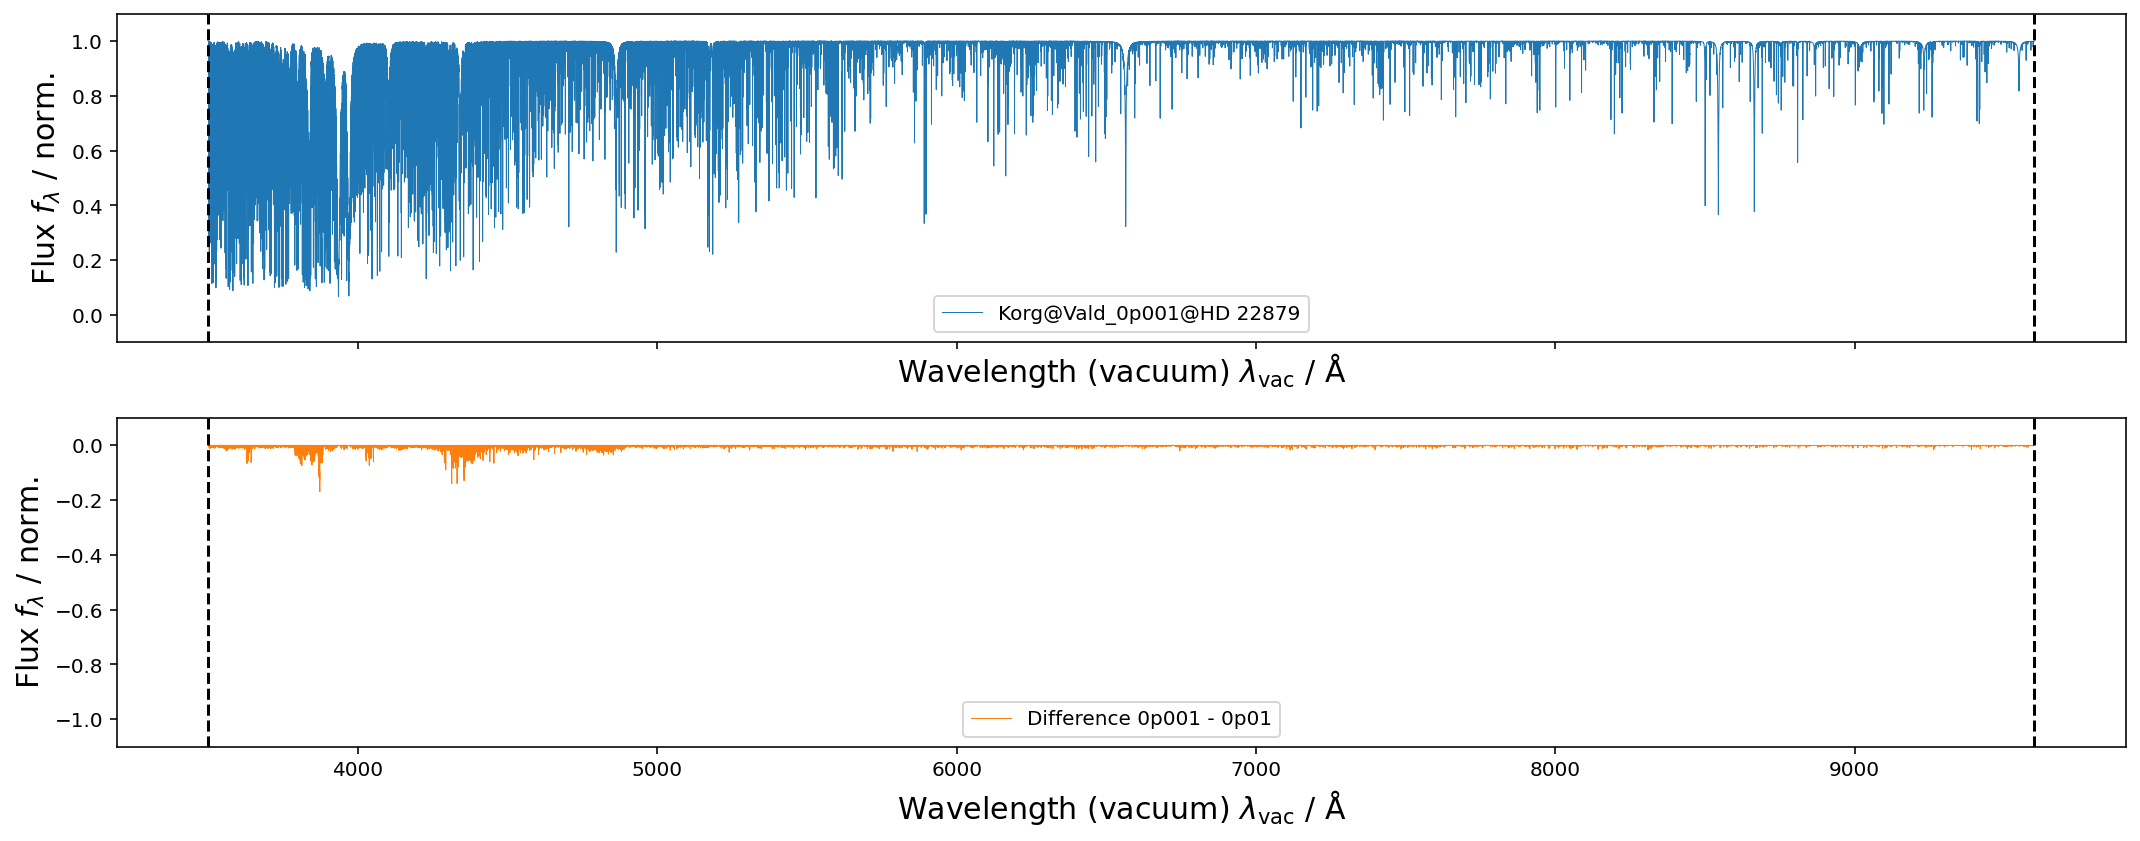

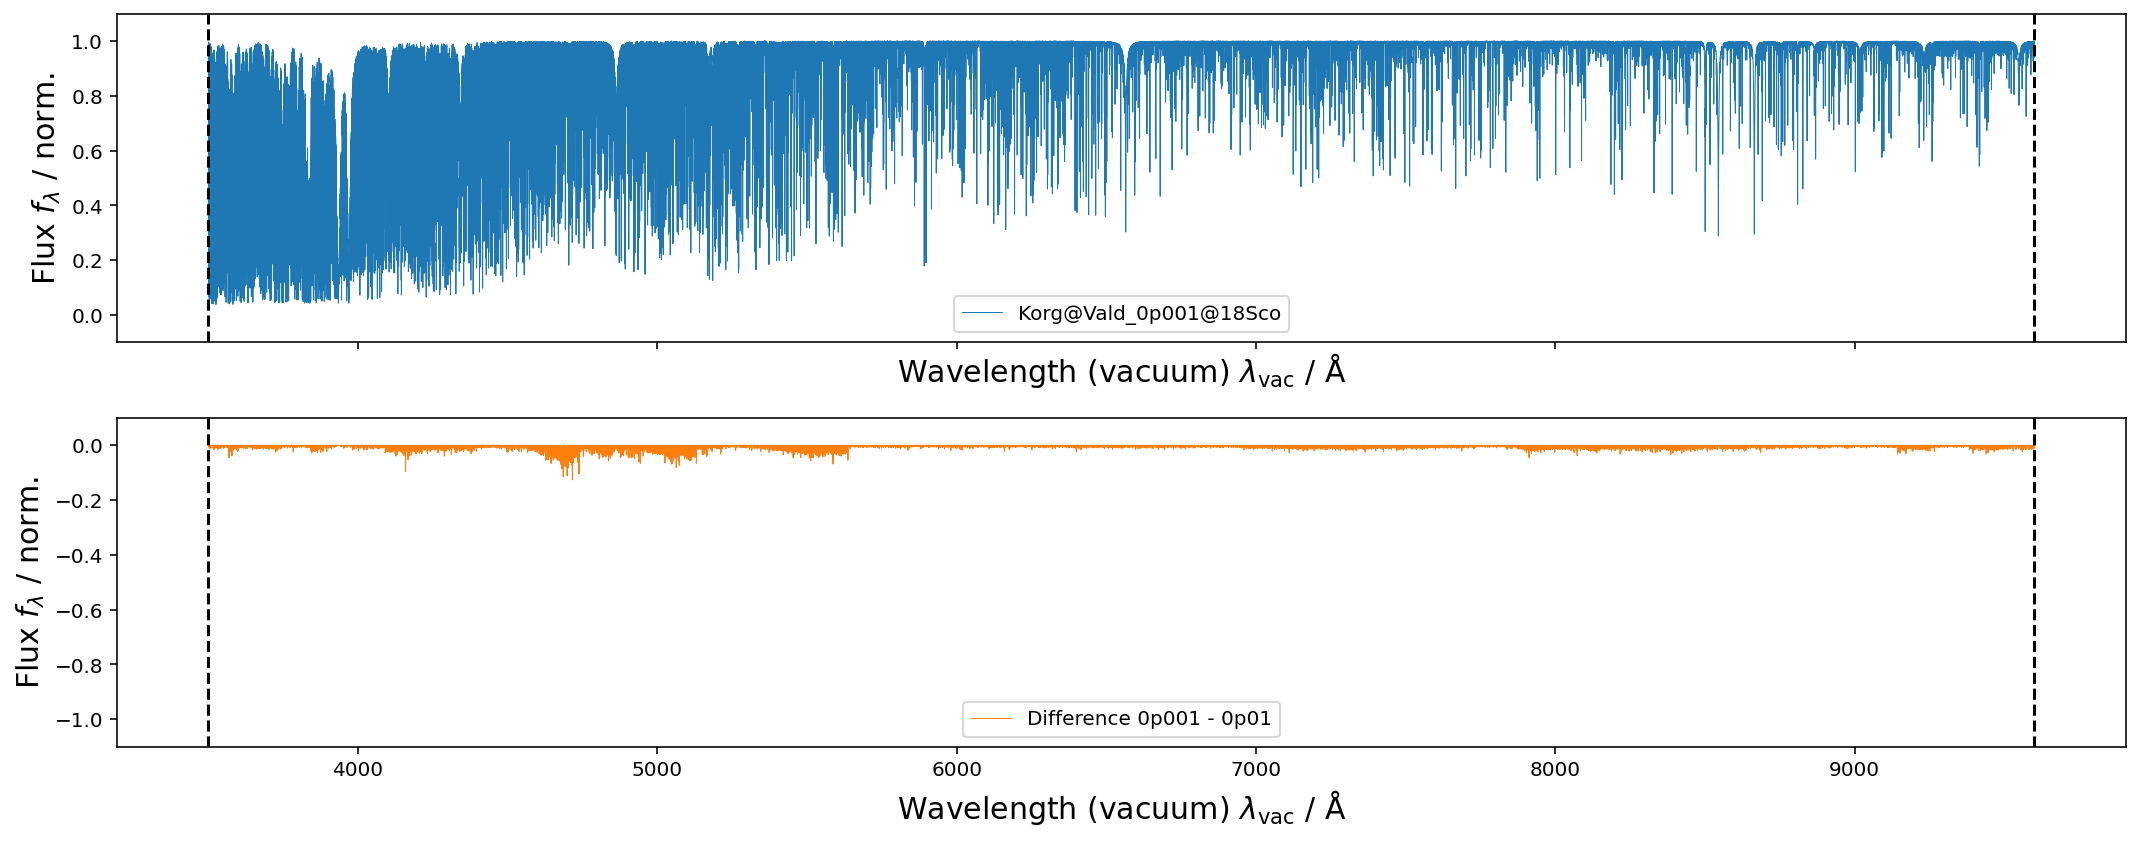

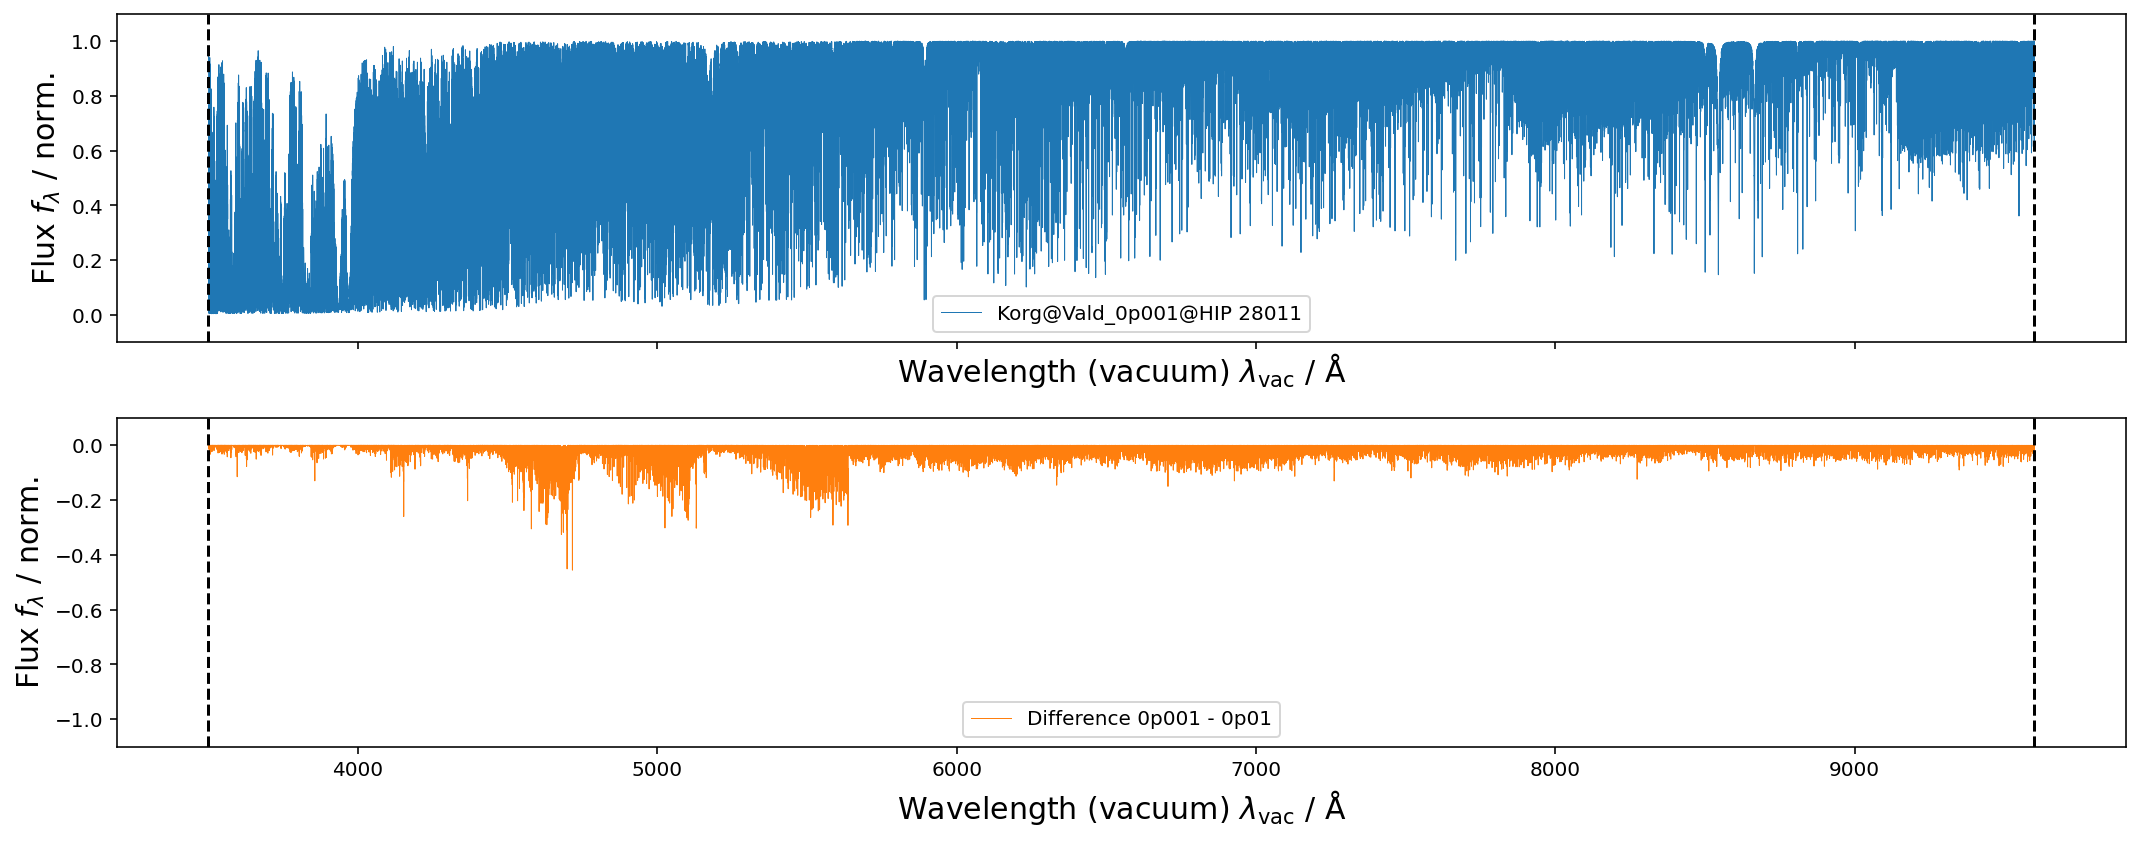

In [9]:
for index, star in enumerate(['Sun','Arcturus','61 Cyg A','HD 22879','18Sco','HIP 28011']):
    short_name = star.lower().replace(' ','')
    f, gs = plt.subplots(2,1,figsize=(15,6),sharex=True)

    ax = gs[0]
    
    try:
        ax.plot(
            korg_fluxes['wavelength_vac'],
            korg_fluxes['flux_'+short_name],
            lw = 0.5,
            label = 'Korg@Vald_0p001@'+star
        )
    except:
        pass
    ax.axvline(korg_fluxes['wavelength_vac'][0] ,c = 'k',ls='dashed')
    ax.axvline(korg_fluxes['wavelength_vac'][-1],c = 'k',ls='dashed')
    
    ax.set_xlabel(r'Wavelength (vacuum) $\lambda_\mathrm{vac}~/~\mathrm{\AA}$',fontsize=15)
    ax.set_ylabel(r'Flux $f_\lambda~/~\mathrm{norm.}$',fontsize=15)
    ax.legend()
    ax.set_ylim(-0.1,1.1)
    
    ax = gs[1]
        
    try:
        ax.plot(
            korg_fluxes['wavelength_vac'],
            korg_fluxes['flux_'+short_name] - korg_fluxes['flux_'+short_name+'_0p01'],
            lw = 0.5, c = 'C1', label = 'Difference 0p001 - 0p01'
        )
    except:
        pass
    
    ax.axvline(korg_fluxes['wavelength_vac'][0] ,c = 'k',ls='dashed')
    ax.axvline(korg_fluxes['wavelength_vac'][-1],c = 'k',ls='dashed')
    
    ax.set_xlabel(r'Wavelength (vacuum) $\lambda_\mathrm{vac}~/~\mathrm{\AA}$',fontsize=15)
    ax.set_ylabel(r'Flux $f_\lambda~/~\mathrm{norm.}$',fontsize=15)
    ax.legend()
    ax.set_ylim(-1.1,0.1)
    
    plt.tight_layout()
    plt.show()
    plt.close()